In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wquantiles

from scipy.stats import trim_mean
from statsmodels import robust
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

import seaborn as sns

In [8]:
state = pd.read_csv('../../data/state.csv')
dfw = pd.read_csv('../../data/dfw_airline.csv')
sp500_sym = pd.read_csv('../../data/sp500_sectors.csv')
sp500_px = pd.read_csv('../../data/sp500_data.csv.gz', index_col=0)
kc_tax = pd.read_csv('../../data/kc_tax.csv.gz')
lc_loans = pd.read_csv('../../data/lc_loans.csv')
airline_stats = pd.read_csv('../../data/airline_stats.csv')

In [9]:
print("1.3.3")
print(state['Population'].mean())
print(trim_mean(state['Population'], 0.1))
print(state['Population'].median())

print(np.average(state['Murder.Rate'], weights=state['Population']))
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

1.3.3
6162876.3
4783697.125
4436369.5
4.445833981123393
4.4


In [10]:
print("1.4.4")
print(state['Population'].std())
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))
print(robust.scale.mad(state['Population']))

1.4.4
6848235.347401142
4847308.0
3849876.1459979336


1.5.1
0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


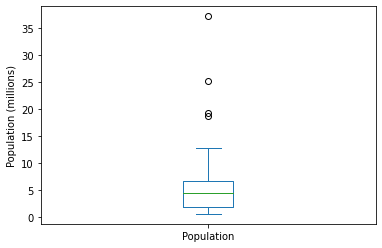

In [11]:
print("1.5.1")
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))
ax = (state['Population']/1_000_000).plot.box()
ax.set_ylabel('Population (millions)')
plt.show()

1.5.2
(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


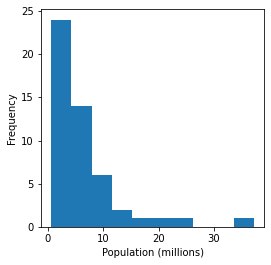

In [12]:
print("1.5.2")
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())
ax = (state['Population']/1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')
plt.show()

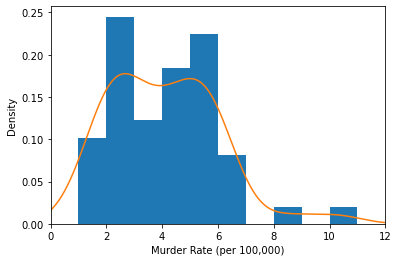

In [13]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], bins=range(1, 12))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')
plt.show()

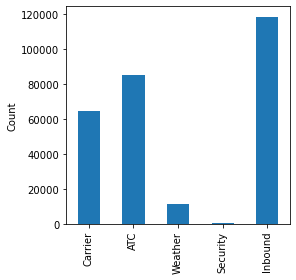

In [14]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_ylabel('Count')
plt.show()

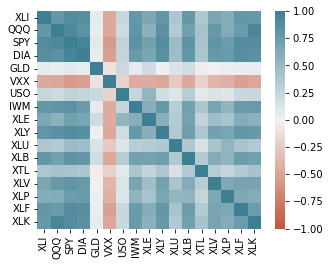

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))
etfs = sp500_px.loc[sp500_px.index > '2012-07-01',
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
sns.heatmap(etfs.corr(), vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True))
plt.show()

In [16]:
# ellipse type corr plot
def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect': 'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                            norm=Normalize(vmin=-1, vmax=1),
                            transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


/var/folders/v9/bhk8vppn70z1vk01pmqzjvd40000gn/T/ipykernel_2502/3511607170.py:2: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = fig.colorbar(m)


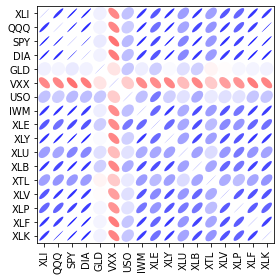

In [17]:
m = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

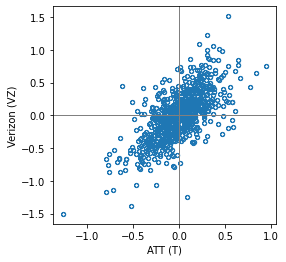

In [18]:
# Determine telecommunications symbols
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]

ax = telecom.plot.scatter(x="T", y="VZ", figsize=(4,4), marker="$\u25EF$")
ax.set_xlabel("ATT (T)")
ax.set_ylabel("Verizon (VZ)")
ax.axhline(0, color="grey", lw=1)
ax.axvline(0, color="grey", lw=1)

(432693, 3)


Text(0, 0.5, 'Tax-Assesed Value')

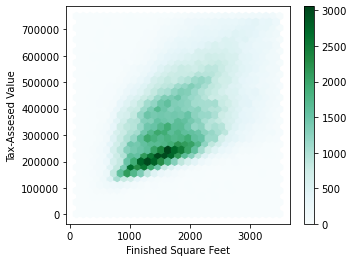

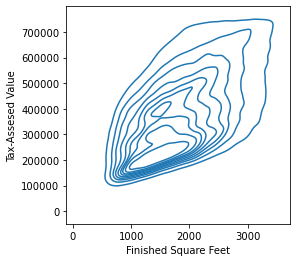

In [19]:
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) &
                        (kc_tax.SqFtTotLiving > 100) &
                        (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)

ax = kc_tax0.plot.hexbin(x="SqFtTotLiving", y="TaxAssessedValue",
                            gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax-Assesed Value')

fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(data=kc_tax0, x="SqFtTotLiving", y="TaxAssessedValue", ax=ax)
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax-Assesed Value')

In [20]:
crosstab = lc_loans.pivot_table(index='grade', columns='status',
                                aggfunc=lambda x: len(x), margins=True)

df = crosstab.loc['A':'G', :].copy()
df.loc[:, 'Charged Off':'Late'] = df.loc[:, 'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df

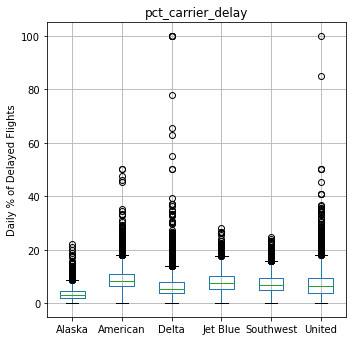

In [21]:
airline_stats.head()
ax = airline_stats.boxplot(by="airline", column='pct_carrier_delay',
                            figsize=(5, 5))
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.suptitle("")

plt.tight_layout()
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/tf26/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


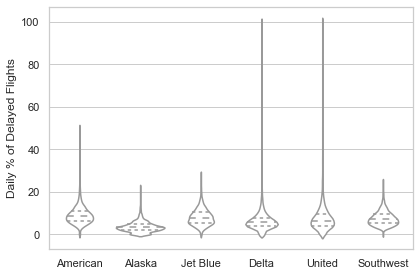

In [22]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(airline_stats.airline, airline_stats.pct_carrier_delay,
                    inner='quartile', color='white')
ax.set_xlabel("")
ax.set_ylabel("Daily % of Delayed Flights")
plt.tight_layout()

        TaxAssessedValue  SqFtTotLiving  ZipCode
3               361000.0           2000  98108.0
4               459000.0           3150  98108.0
10              202000.0            830  98108.0
11              210000.0           1130  98108.0
12              193000.0           1560  98108.0
...                  ...            ...      ...
498049          346000.0           1430  98105.0
498050          463000.0           1610  98105.0
498051          553000.0           1580  98105.0
498052          571000.0           1840  98105.0
498053          694000.0           2420  98105.0

[19690 rows x 3 columns]


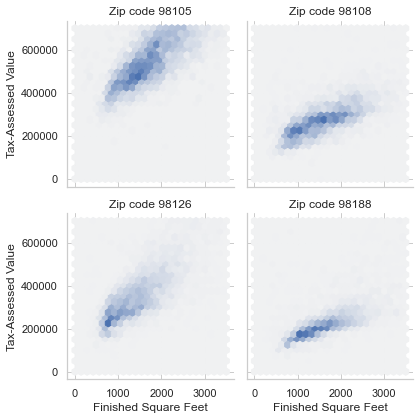

In [23]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes), :]
print(kc_tax_zip)

def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue',
        extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax-Assessed Value')
g.set_titles('Zip code {col_name:.0f}')
